In [1]:
%matplotlib inline
import pymongo

import numpy as np
import pandas as pd

from IPython.display import display
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from util import *

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.container { min-height:40% !important; }</style>"))

In [3]:
# Configuration of the database
client = pymongo.MongoClient("mongodb://localhost:27017/")
database = client['thesis']
db_dumps = database['dumps']
db_boards = database['boards']

# List of recurring data
boards_ids = list(set(i['board_id'] for i in db_dumps.find({},{"_id": 0, "board_id": 1})))

print("Number of boards: " + str(len(boards_ids)))

Number of boards: 67


In [4]:
# Configuration of data frames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [5]:
# Extract useful data from the board id
extracted_id_cols = ['Board', 'Wafer', 'Lot', 'X', 'Y']

extracted_id_df = pd.DataFrame(columns=extracted_id_cols)

for board_id in boards_ids:
    data = {'Board': board_id,
            'Wafer': board_id[2:4],
            'Lot': board_id[4:18],
            'X': int(board_id[21:23], 16),
            'Y': int(board_id[18:20], 16)}
    
    # Insert the extracted data into another collection
    # db_boards.insert_one(data) 
    extracted_id_df = extracted_id_df.append(data, ignore_index=True)

In [6]:
def unique_sorted_values_plus_ALL(array):
    unique = list(set(array))
    unique.sort()
    unique.insert(0, 'ALL')
    return unique

In [7]:
dropdown_wafer = widgets.Dropdown(options=unique_sorted_values_plus_ALL(extracted_id_df['Wafer']))

wafer_output = widgets.Output()

# Sort the data frame and show it
# extracted_id_df.sort_values(['Wafer', 'X', 'Y'], ascending=[True, True, True], inplace=True)
# extracted_id_df
# display(dropdown_wafer)

def dropdown_wafer_eventhandler(change):
    wafer_output.clear_output()
    with wafer_output:
        if (change.new == 'ALL'):
            display(extracted_id_df)
        else:
            display(extracted_id_df[extracted_id_df['Wafer'] == change.new])
        
dropdown_wafer.observe(dropdown_wafer_eventhandler, names='value')

display(dropdown_wafer)

Dropdown(options=('ALL', '30', '34', '35'), value='ALL')

In [8]:
display(wafer_output)

Output()

In [9]:
# Loop over all the boards and calculate the diff in their data
# Filter out the ones that are too high or too low

column_names = ["Board", "Region", "Id_1", "Id_2", "Diff"]

final_df = pd.DataFrame(columns=column_names) # To handle final results

for bid in boards_ids[3:]:
    df = pd.DataFrame(columns=column_names)
    data = compare_dumps_one_board(bid, df)
    data_valid = filter_results_df(data, 5, 50)
    
    final_df = final_df.append(data_valid, ignore_index=True)

# Regions of memory with the differences that we want
good_regions = list(set(final_df['Region']))
good_df = pd.DataFrame(columns=['Region', 'Mean_Diff', 'Deviation'])

# Iterate over all these regions and calculate the mean diff
# for all the boards
for region in good_regions:
    region_selector = final_df['Region'] == region
    region_df = final_df[region_selector]

    good_df = good_df.append({'Region': region,
                              'Num_Samples': len(region_df.index),
                              'Mean_Diff': region_df['Diff'].mean(),
                              'Deviation': region_df['Diff'].std()},
                             ignore_index=True)
    


In [10]:
good_df.sort_values(['Mean_Diff'], ascending=[True], inplace=True)

good_df.head(5)

,Region,Mean_Diff,Deviation,Num_Samples
7,0x20000600,20.025873,12.835503,154.0
2,0x20003e00,24.485309,3.339051,159.0
27,0x20002000,27.589286,4.662080,105.0
4,0x20000c00,27.853423,6.585910,105.0
26,0x20002e00,28.350074,5.154604,105.0


In [9]:
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show

output_notebook()

Loading BokehJS ...

In [10]:
plot_memory_regions_bokeh(boards_ids[2], 0, 5, show_every=True)

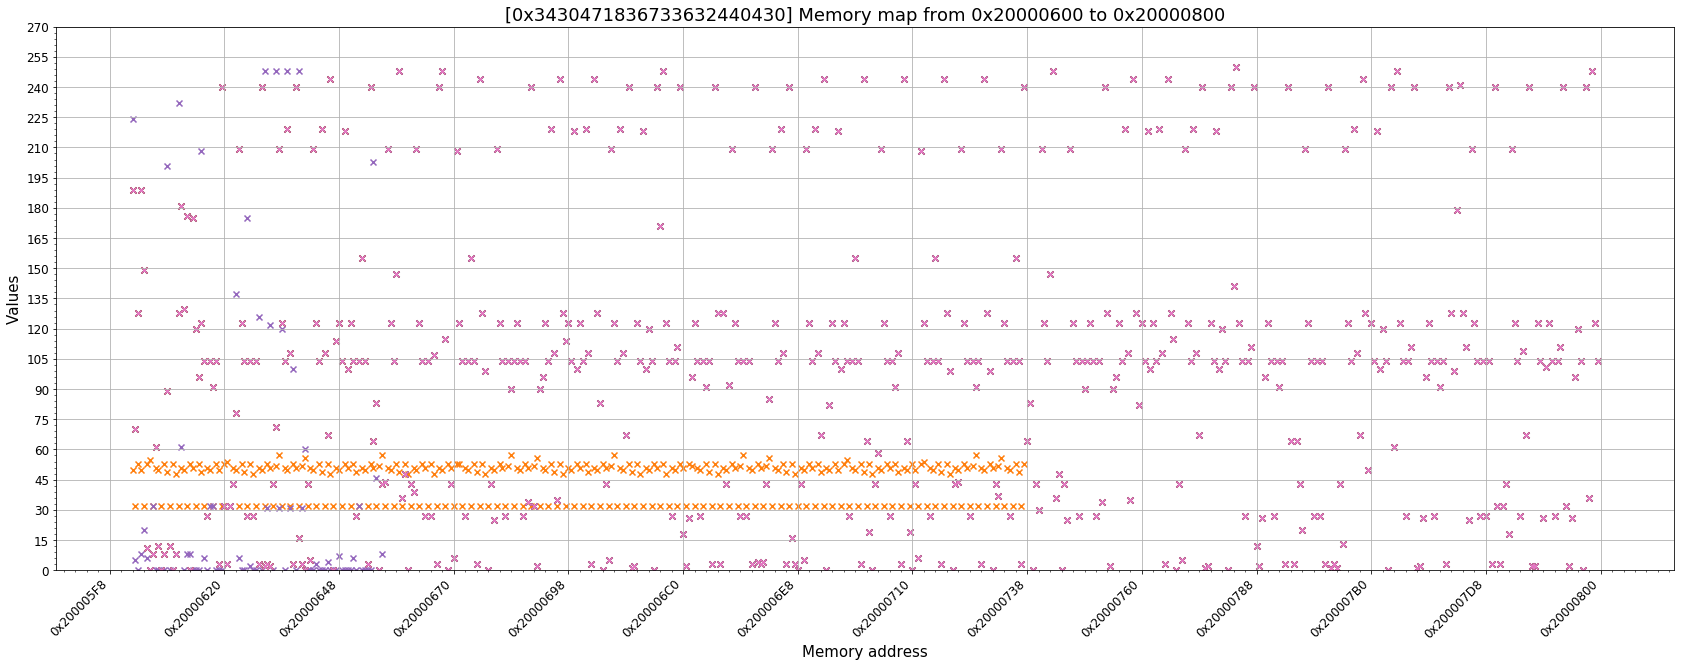

In [17]:
for bid in boards_ids[0:7]:
    plot_memory_regions(bid, add_to_off(0x20000600), add_to_off(0x20000600) + 1, show_every=False)

In [26]:
# Compare the same memory region in different boards

# memory_regions_uut = list(set([mem_pos['mem_pos'] for mem_pos in board_dumps]))
# final_column_names = ["Board_1", "Board_2", "Region", "Id_1", "Id_2", "Diff"]

# fdata_df = pd.DataFrame(columns=final_column_names)
    
# for region_uut in memory_regions_uut:
#     dumps_board_0 = list(db_dumps.find({'mem_pos': region_uut, 'board_id': boards_ids[0]}))
#     dumps_board_1 = list(db_dumps.find({'mem_pos': region_uut, 'board_id': boards_ids[1]}))

#     num_samples = min(len(dumps_board_0), len(dumps_board_1))

#     for sample in range(num_samples):
#         diff = calculate_diff_one_board(dumps_board_0[sample], dumps_board_1[sample])
    
#         data = {'Board_1': dumps_board_0[sample]['board_id'],
#                 'Board_2': dumps_board_1[sample]['board_id'],
#                 'Region': region_uut,
#                 'Id_1': str(dumps_board_0[sample]['_id']),
#                 'Id_2': str(dumps_board_1[sample]['_id']),
#                 'Diff': diff}
    
#         fdata_df = fdata_df.append(data, ignore_index=True)

# final_is_valid = fdata_df['Diff'] < 70
# fdata_df = fdata_df[final_is_valid]

# fdata_df.sort_values(['Diff'], ascending=[True], inplace=True)
# fdata_df

In [ ]:
# Compare all memory regions in all of the boards
# Filter only the ones with a low difference
#
# boards_dumps_df holds all the dump differences of the same
# board which are in the good range

column_names = ["Board", "Region", "Id_1", "Id_2", "Diff"]
boards_dumps_df = pd.DataFrame(columns=column_names)

output = parallelize_call_ma(compare_dumps_one_board, boards_ids[2:])

for o_df in output[0]:
    o_df = filter_results_df(o_df, 5, 21)
    boards_dumps_df = boards_dumps_df.append(o_df, ignore_index=True)

In [218]:
print(f'Number of results: {len(boards_dumps_df.index)}')
boards_dumps_df.head(10)

Number of results: 367


,Board,Region,Id_1,Id_2,Diff
0,0x343047A367336324402D0,0x20000600,5dbb0b4b330b053b8318d29d,5dbb0b56330b053b8318d2bd,14.257812
1,0x343047A367336324402D0,0x20003e00,5dbb0b43330b053b8318d299,5dbb0b5a330b053b8318d2d9,19.921875
2,0x3430473367336322523F0,0x20003e00,5dbafe4ca710478051e8192b,5dbafe81a710478051e8194b,20.507812
3,0x3430473367336322523F0,0x20003e00,5dbafe81a710478051e8194b,5dbafe9fa710478051e8196b,20.312500
4,0x30314710303537323E03A0,0x20000600,5dbb07d5706c1c4902b28b54,5dbb0875706c1c4902b28c34,8.789062
5,0x30314710303537323E03A0,0x20001200,5dbb07d5706c1c4902b28b5a,5dbb0876706c1c4902b28c3a,19.140625
6,0x30314710303537323E03A0,0x20001600,5dbb07d6706c1c4902b28b5c,5dbb0876706c1c4902b28c3c,20.898438
7,0x30314710303537323E03A0,0x20001000,5dbb07d5706c1c4902b28b59,5dbb0876706c1c4902b28c39,16.601562
8,0x30314710303537323E03A0,0x20003400,5dbb07d7706c1c4902b28b6b,5dbb0878706c1c4902b28c4b,20.312500
9,0x30314710303537323E03A0,0x20003000,5dbb07d7706c1c4902b28b69,5dbb0877706c1c4902b28c49,20.312500


In [224]:
# Calculate the mean and std_deviation of the diff from
# the data frame with the data in the range we desire

boards_umt_df = boards_dumps_df

# Not all boards are within the good range we want
good_boards = list(set(boards_umt_df['Board']))
good_regions = list(set(boards_umt_df['Region']))

print(f'Number of boards: {len(good_boards)}')
print(f'Regions of interest [{len(good_regions)}]: {good_regions}')

mean_df = pd.DataFrame(columns=['Board', 'Region', 'Num_Samples', 'Mean_Diff', 'Deviation'])

# Iterate over all the good boards
for gb in good_boards:
    
    board_selector = boards_umt_df['Board'] == gb
    board_ut_df = boards_umt_df[board_selector]
    mem_regions = list(set(board_ut_df['Region']))
    
    # Iterate over the good regions of the board
    for region in mem_regions:
        region_selector = board_ut_df['Region'] == region
        board_region_df = board_ut_df[region_selector]
            
        data = {'Board': gb,
                'Region': region,
                'Num_Samples': len(board_region_df.index),
                'Mean_Diff': board_region_df['Diff'].mean(),
                'Deviation': board_region_df['Diff'].std()}
        
        mean_df = mean_df.append(data, ignore_index=True)

Number of boards: 11
Regions of interest [25]: ['0x20001800', '0x20001a00', '0x20002a00', '0x20000600', '0x20001200', '0x20001600', '0x20001000', '0x20003800', '0x20003400', '0x20003000', '0x20003200', '0x20000e00', '0x20001c00', '0x20003e00', '0x20000800', '0x20000a00', '0x20003a00', '0x20002e00', '0x20001e00', '0x20000c00', '0x20002800', '0x20002000', '0x20001400', '0x20002c00', '0x20003c00']


In [226]:
mean_df.sort_values(['Board', 'Region'], ascending=[True, True], inplace=True)
print(f'Number of results: {len(mean_df.index)}')
mean_df

Number of results: 51


,Board,Region,Num_Samples,Mean_Diff,Deviation
6,0x30314710303537323E0372,0x20000600,34,8.978631,0.660126
17,0x30314710303537323E0372,0x20000800,25,19.835938,0.936822
18,0x30314710303537323E0372,0x20000a00,10,20.039062,0.505973
22,0x30314710303537323E0372,0x20000c00,28,19.294085,1.518809
14,0x30314710303537323E0372,0x20000e00,17,19.772518,0.712721
9,0x30314710303537323E0372,0x20001000,10,19.804688,0.480185
7,0x30314710303537323E0372,0x20001200,13,20.177284,0.512949
25,0x30314710303537323E0372,0x20001400,4,20.703125,0.000000
8,0x30314710303537323E0372,0x20001600,3,20.312500,0.000000
3,0x30314710303537323E0372,0x20001800,2,19.140625,0.000000


In [ ]:
# TODO: Make a heatmap with the mean and deviation of the memory of a board to show how it changes